In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport deepsvr

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
from analysis_utils.Analysis import print_accuracy_and_classification_report, predict_classes, get_somatic_error_type

sns.set_style("white")
sns.set_context('poster')

In [59]:
# Pull in training data
training_data = pd.read_pickle('data/training_data_preprocessed.pkl')
training_data.sort_index(axis=1, inplace=True)

In [60]:
# Remove AML31 case
aml31_training = training_data[training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]
training_data = training_data[~training_data.index.str.contains('fSsMNn1DZ3AIDGk=')]

In [61]:
# Show the calls associate with training data
training_data.groupby('call').size()

call
a    10643
f     8854
g     3122
s    18381
dtype: int64

In [70]:
training_data.columns

Index(['call', 'disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma', 'normal_VAF', 'normal_depth',
       'normal_other_bases_count', 'normal_ref_avg_basequality',
       'normal_ref_avg_clipped_length',
       'normal_ref_avg_distance_to_effective_3p_end',
       'normal_ref_avg_distance_to_q2_start_in_q2_reads',
       'normal_ref_avg_mapping_quality',
       'normal_ref_avg_num_mismaches_as_fraction',
       'normal_ref_avg_pos_as_fraction', 'normal_ref_avg_se_mapping_quality',
       'normal_ref_avg_sum_mismatch_qualities', 'normal_ref_count',
       'normal_ref_num_minus_strand', 'normal_ref_num_plus_strand',
       'normal_ref_num_q2_containing_reads', 'normal_var_avg_basequality',
       'normal_var_avg_clipped_length',
       'normal_var_avg_distance_to_effective_3p_end',
       'normal_var_avg_distance_to_q2_start_in_q2_reads',
       'normal_var_avg_m

In [62]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Somatic, ambigous, fail classifier

In [63]:
# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')
three_class.sort_index(axis=1, inplace=True)

In [64]:
# Show the calls associate with training data
three_class.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [65]:
# Get labels for training data
Y = three_class.call.values
# Get training data as numpy array
X = training_data.drop(['call'], axis=1).astype(float).values

In [11]:
Y.shape

(41000,)

In [12]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [13]:
# Determine shape of training data features for cross-validation
X_test.shape

(13530, 71)

In [14]:
# Determine shape of training data calls for cross-validation
Y_train.shape

(27470,)

In [15]:
# Set parameters for the Gradient Boost Model
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)

In [16]:
# Perform cross validation and pull AUC for various splits
auc = []
for n in [10, 50, 100, 150, 200, 250]:
    est = GradientBoostingClassifier(n_estimators=n, max_features = 8 , random_state=0)
    probs = cross_val_predict(est, X_train, Y_train, cv=kfold, method='predict_proba')
    temp_auc = []
    for j in range(Y_one_hot.shape[1]):
        temp_auc.append(metrics.roc_auc_score(Y_one_hot[:, j], probs[:, j]))
    auc.append(temp_auc)
    print('Test AUC for {0} trees: '.format(n), temp_auc)
    print('---------------------------------------------------------')

Test AUC for 10 trees:  [0.9131188749659989, 0.9732778251008092, 0.9480698834778477]
---------------------------------------------------------
Test AUC for 50 trees:  [0.9386529265214748, 0.9848936802990667, 0.9657113176555141]
---------------------------------------------------------
Test AUC for 100 trees:  [0.9482800729593419, 0.9881569782178845, 0.972143198390256]
---------------------------------------------------------
Test AUC for 150 trees:  [0.9524116199391868, 0.9890984665894855, 0.9746399561109945]
---------------------------------------------------------
Test AUC for 200 trees:  [0.9547052601997712, 0.9896018340066244, 0.9759255483112157]
---------------------------------------------------------
Test AUC for 250 trees:  [0.9559516172926866, 0.9898356605522958, 0.9767075056796993]
---------------------------------------------------------


In [17]:
for n in [300,500,1000]:
    est = GradientBoostingClassifier(n_estimators=n, max_features = 8 , random_state=0)
    probs = cross_val_predict(est, X_train, Y_train, cv=kfold, method='predict_proba')
    temp_auc = []
    for j in range(Y_one_hot.shape[1]):
        temp_auc.append(metrics.roc_auc_score(Y_one_hot[:, j], probs[:, j]))
    auc.append(temp_auc)
    print('Test AUC for {0} trees: '.format(n), temp_auc)
    print('---------------------------------------------------------')

Test AUC for 300 trees:  [0.9569409306820201, 0.9900025988921762, 0.9772833418977637]
---------------------------------------------------------
Test AUC for 500 trees:  [0.9584554905922601, 0.9902548373303527, 0.9782704820399413]
---------------------------------------------------------
Test AUC for 1000 trees:  [0.958847390162102, 0.9902044627515904, 0.9787638858842961]
---------------------------------------------------------


Since we are not getting significant improvement after 150 trees, we will continue from there

In [18]:
# Set parameters for the extimator
estimator = GradientBoostingClassifier(n_estimators=150, max_features = 8 , random_state=0)

In [19]:
# Perform cross validation
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')
probabilities.shape

(27470, 3)

In [20]:
# Save the probabilities in /data folder
np.save('data/gradient_boost_estimators.npy', probabilities)

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [21]:
# print accuracy report
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.8817983254459411

Cross validation classification report

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      7189
           1       0.91      0.91      0.91      8015
           2       0.89      0.93      0.91     12266

   micro avg       0.88      0.88      0.88     27470
   macro avg       0.88      0.87      0.87     27470
weighted avg       0.88      0.88      0.88     27470
 samples avg       0.88      0.88      0.88     27470



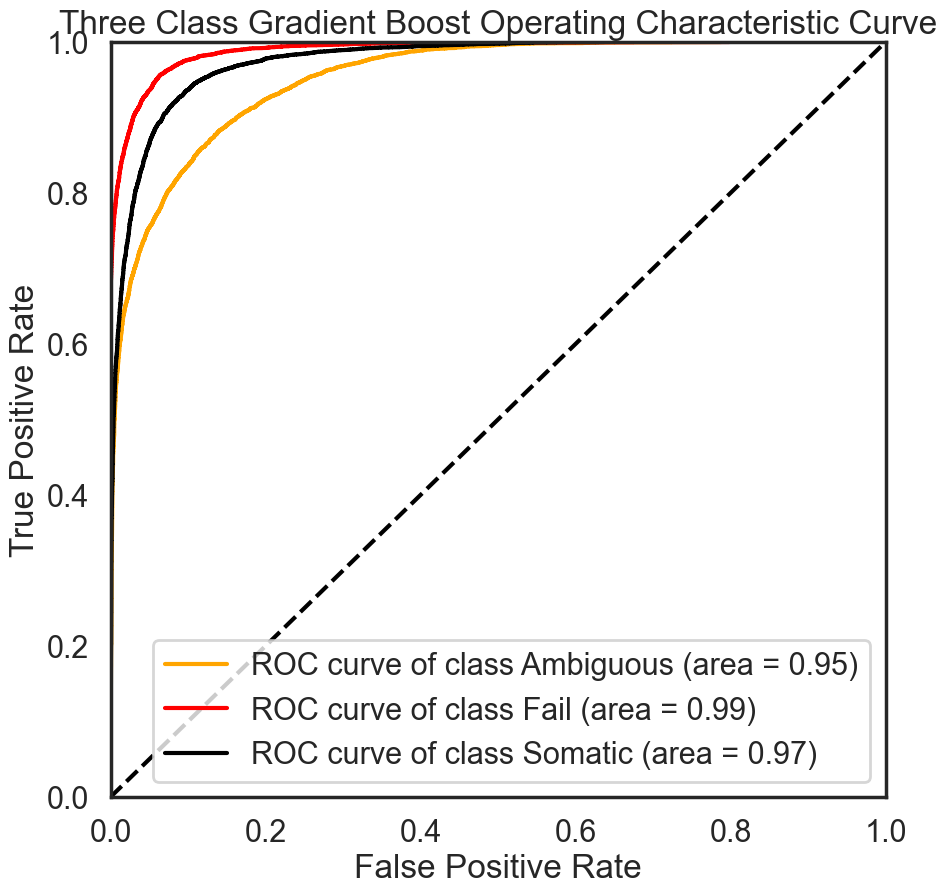

In [22]:
# Plot ROC for Gardient Boost model
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots(figsize=(10,10),dpi=100)
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Three Class Gradient Boost Operating Characteristic Curve', ax)

confidence intervals +-:  [0.00049661 0.00403545 0.00659351 0.00910379 0.01056542 0.0112177
 0.01035384 0.00754344 0.00431639 0.00085042]


C:\Users\shubh\Documents\applied machine learning\DeepSVR\analysis_utils\ClassifierPlots.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([0, 1], [0, 1], 'k--', color='grey', linewidth=1)


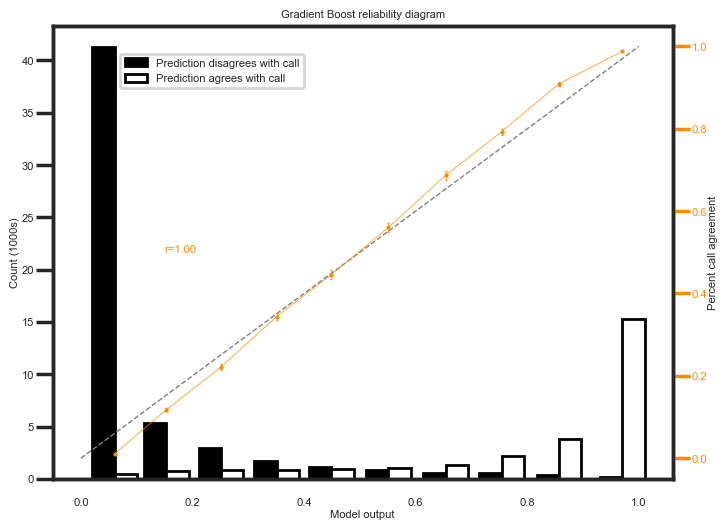

In [23]:
# Plot reliability diagram for Gradient Boost Model
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', 'Gradient Boost reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Feature importance analysis

In [24]:
# Rebuild Gradient Boost model
gb_model = estimator.fit(X_train, Y_train)

In [25]:
print(X_train)
print(X_train.shape)
print(Y_train.shape)

[[0.         0.         0.         ... 0.00042997 0.00013441 0.0001225 ]
 [0.         0.         0.         ... 0.00042997 0.00067204 0.00073502]
 [0.         0.         0.         ... 0.00042997 0.00094086 0.00085753]
 ...
 [0.         0.         0.         ... 0.00032248 0.00026882 0.00024501]
 [0.         0.         0.         ... 0.00075245 0.00201613 0.00208257]
 [0.         0.         0.         ... 0.00032248 0.00026882 0.00036751]]
(27470, 71)
(27470,)


In [26]:
gb_model

GradientBoostingClassifier(max_features=8, n_estimators=150, random_state=0)

In [27]:
# Sum the feature importance metrics for one-hot encoded variables
# (Feature importance calculation in scikit-learn is outlined 
# here https://stackoverflow.com/a/15821880/3862525).
# Since the importances are calculated with the same denominator, summing is
# appropriate
def sum_features(feature_import, label):
    starts_with_label = feature_import.feature.str.startswith(label)
    return feature_import.importance[starts_with_label].sum()

In [28]:
# Create function to determine the feature importance 
def create_feature_importance_plot(trained_model, save_fp='gradient_boost_feature_import.pkl'):
    #print(training_data)
    #print(training_data.shape)
    feature_import = pd.DataFrame([training_data.drop(['call'], axis=1).columns.values,trained_model.feature_importances_]).T
    print(feature_import)
    print(feature_import.shape)
    feature_import.columns = ['feature', 'importance']
    summed_importances = []
    for label in ['disease', 'reviewer']:
        summed_importances.append([label, sum_features(feature_import, label)])
    summed_importances = pd.DataFrame(summed_importances, columns=['feature','importance'])
    feature_import.to_pickle(save_fp)
    feature_import.sort_values('importance', ascending=False, inplace=True)
    feature_import.replace({'feature':{'var':'variant','ref':'reference', 'avg':'average', '_se_':'_single_end_', '3p':'3_prime', '_':' '}}, regex=True, inplace=True)
    plt.figure(figsize=(15, 15))
    sns.barplot(y='feature', x='importance', data=feature_import.head(30), color='darkorange')
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.title('Gradient Boost feature importance')
    

                                       0         1
0                            disease_AML   0.00956
1                            disease_GST   0.00025
2                          disease_MPNST  0.000139
3                           disease_SCLC  0.008947
4                         disease_breast  0.018832
..                                   ...       ...
66  tumor_var_avg_sum_mismatch_qualities  0.028304
67                       tumor_var_count   0.09884
68            tumor_var_num_minus_strand  0.059036
69             tumor_var_num_plus_strand  0.054343
70     tumor_var_num_q2_containing_reads  0.027753

[71 rows x 2 columns]
(71, 2)


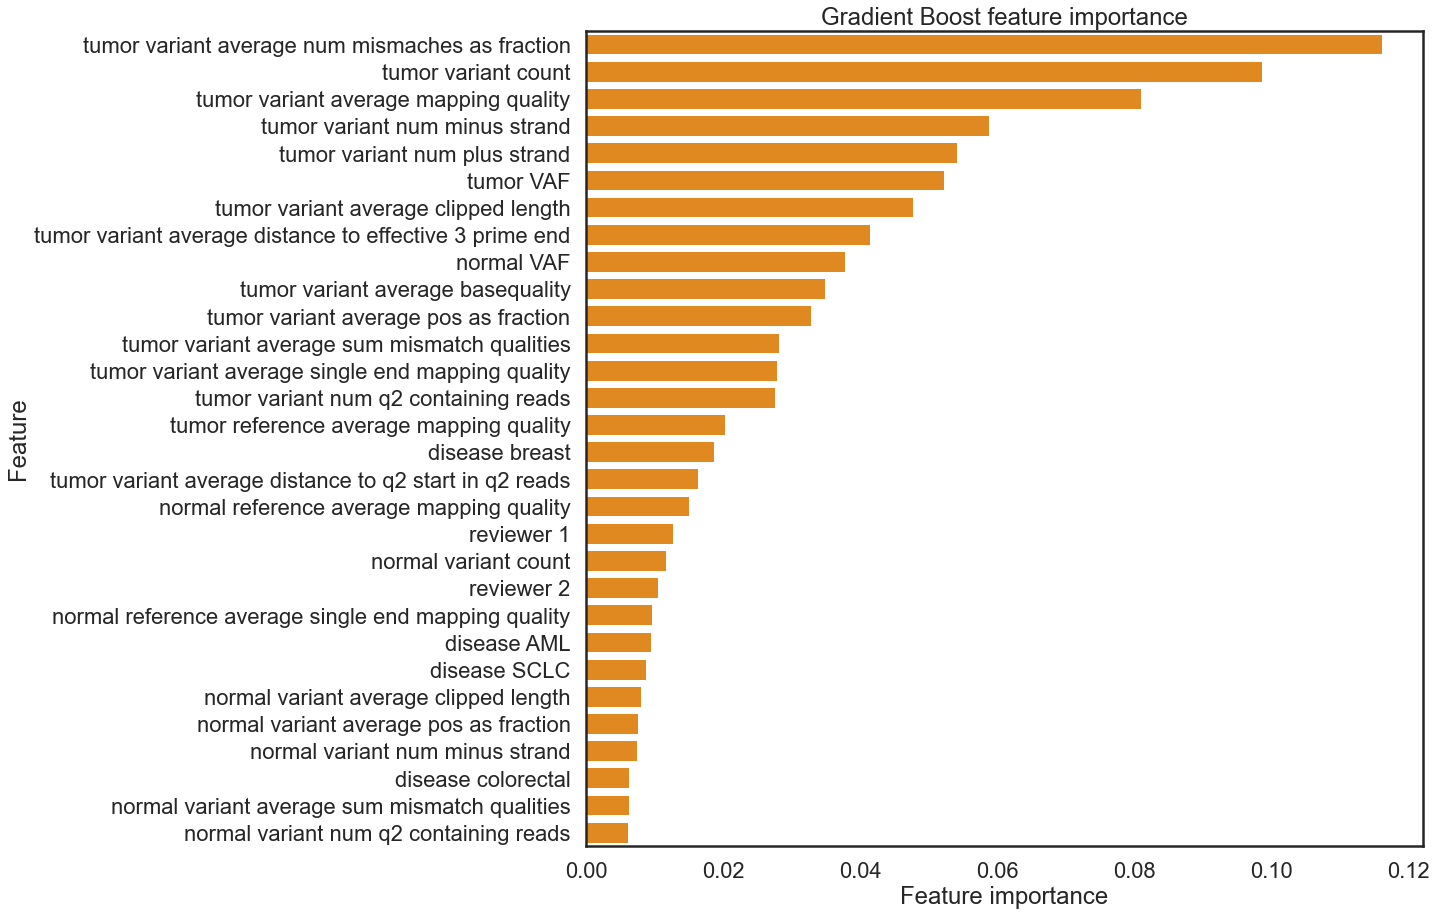

In [29]:
# Plot feature importance graph
create_feature_importance_plot(gb_model)

### Test set performance

In [30]:
# Determine performance on test set
test_prob = gb_model.predict_proba(X_test)

In [31]:
# Transform labels for predictions
Y_test_labels = enc.fit_transform(Y_test)

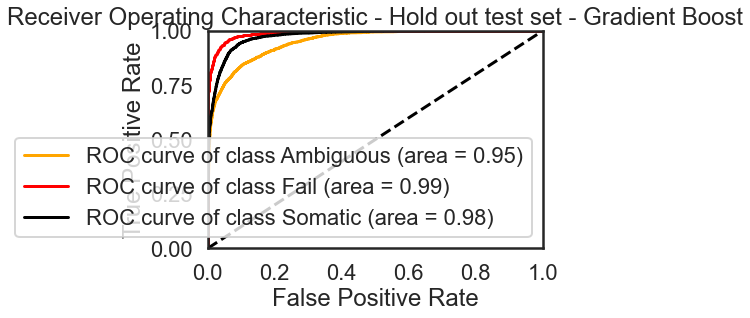

In [32]:
# Plot AUC for test set
fig, ax = plt.subplots()
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set - '
                 'Gradient Boost', ax)

confidence intervals +-:  [0.00070251 0.00570884 0.00919383 0.01301821 0.01507927 0.0163602
 0.01429202 0.01039798 0.00627306 0.00120135]


C:\Users\shubh\Documents\applied machine learning\DeepSVR\analysis_utils\ClassifierPlots.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([0, 1], [0, 1], 'k--', color='grey', linewidth=1)


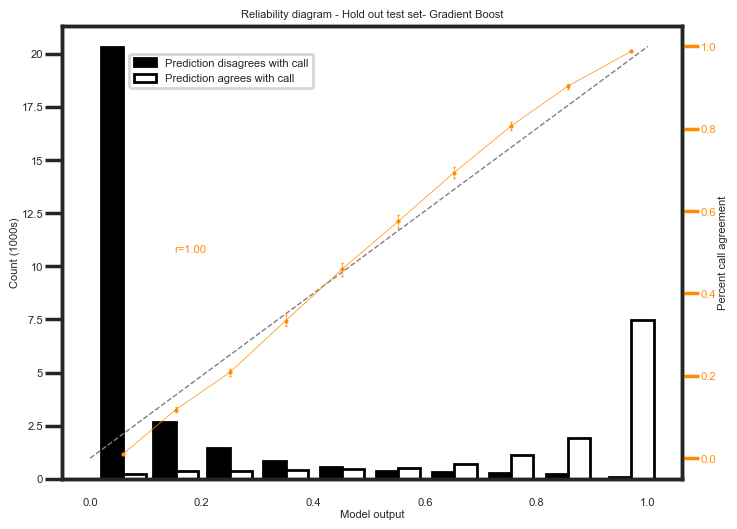

In [33]:
# Plot reliability diagram for test set
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(test_prob, Y_test_labels,
                                 ['Ambiguous','Fail','Somatic'], 
                                 'darkorange', 'Reliability diagram - Hold out test set'
                                 '- Gradient Boost',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Solid vs blood tumor

In [34]:
# Colapse disease types into solid vs liquid tumors
s_v_b = three_class
s_v_b['solid_tumor'] = s_v_b[['disease_GST', 'disease_MPNST', 'disease_SCLC',
                              'disease_breast', 'disease_colorectal', 
                              'disease_glioblastoma', 'disease_melanoma']].apply(any, axis=1).astype(int)
s_v_b.drop(['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma'], axis=1, inplace=True)

In [35]:
# Determine shape of new data set
s_v_b.groupby('call').size()

call
a    10643
f    11976
s    18381
dtype: int64

In [36]:
# Get Labels
Y = s_v_b.call.values
# Get training data as numpy array
X = s_v_b.drop(['call'], axis=1).astype(float).values

In [37]:
# Split data into training set and test set
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.33, random_state=seed)

In [38]:
# Determine shape
X_train.shape

(27470, 63)

In [39]:
# Determine shape
Y_train.shape

(27470,)

In [40]:
# Determine cross validation probabilites
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = somatic

In [41]:
# Show accuracy profile of the cross-validation
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.8777575536949399

Cross validation classification report

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      7189
           1       0.91      0.91      0.91      8015
           2       0.89      0.93      0.91     12266

   micro avg       0.88      0.88      0.88     27470
   macro avg       0.87      0.87      0.87     27470
weighted avg       0.88      0.88      0.88     27470
 samples avg       0.88      0.88      0.88     27470



In [42]:
estimator

GradientBoostingClassifier(max_features=8, n_estimators=150, random_state=0)

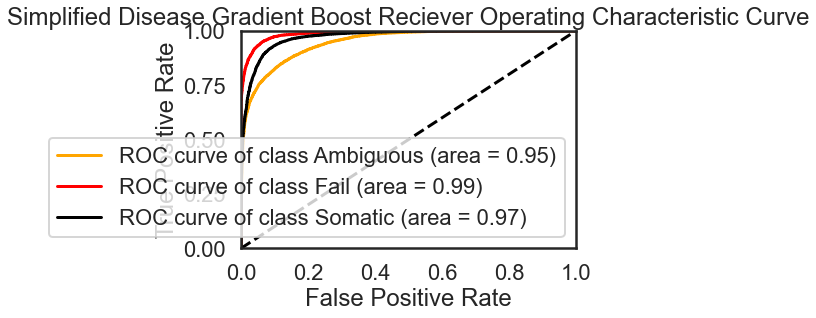

In [43]:
# Plot ROC curves 
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Simplified Disease '
                 'Gradient Boost Reciever Operating Characteristic Curve', ax)

In [44]:
# Plot reliability diagram
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange'," Gradient Boostt reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

SyntaxError: unterminated string literal (detected at line 3) (322938203.py, line 3)

### Test set performance

In [45]:
#Get probabilites for hold out test set
forest = estimator.fit(X_train, Y_train)
test_prob = forest.predict_proba(X_test)

In [46]:
# Add labels
Y_test_labels = enc.fit_transform(Y_test)

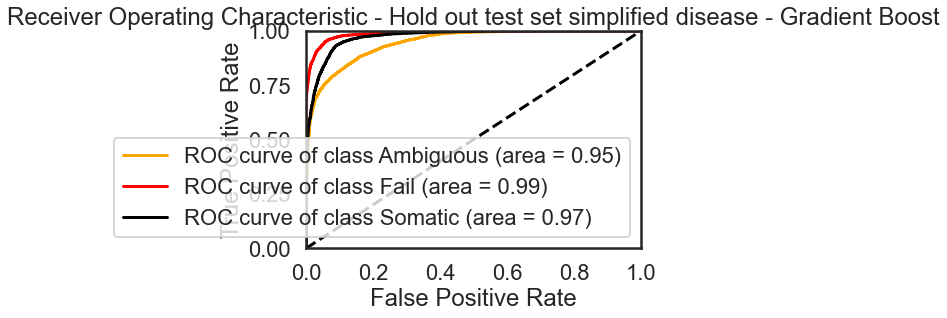

In [47]:
# PLot test set ROC
fig, ax = plt.subplots()
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Receiver Operating '
                 'Characteristic - Hold out test set simplified disease - '
                 'Gradient Boost', ax)

confidence intervals +-:  [0.00073613 0.00538827 0.00894102 0.01206668 0.01489842 0.01533251
 0.01306994 0.00976778 0.00628063 0.00127241]


C:\Users\shubh\Documents\applied machine learning\DeepSVR\analysis_utils\ClassifierPlots.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([0, 1], [0, 1], 'k--', color='grey', linewidth=1)


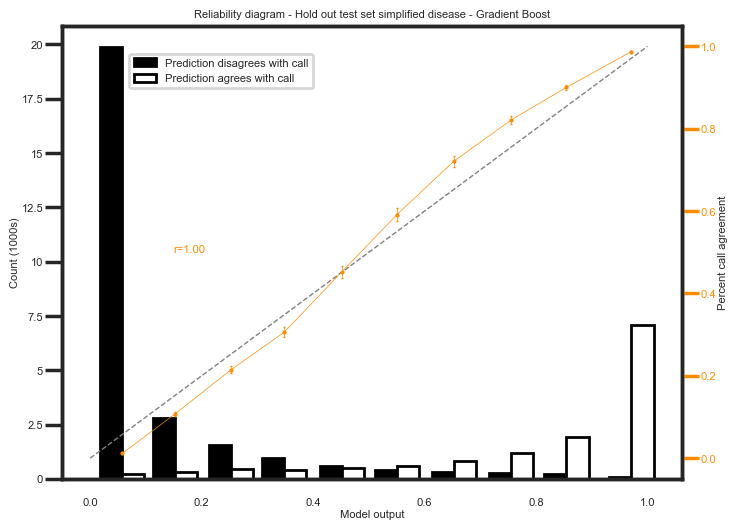

In [48]:
# Plot test set reliability diagram
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(test_prob, Y_test_labels,
                                 ['Ambiguous','Fail','Somatic'], 
                                 'darkorange', 'Reliability diagram - Hold out test set '
                                 'simplified disease - Gradient Boost',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

## Remove reviewer to simulate performance on de novo datasets

In [49]:
# Get Labels
Y = three_class.call.values
# Get training data as numpy array
s_v_b.sort_index(axis=1, inplace=True)
X = s_v_b.drop(['call', 'reviewer_1', 'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1).astype(float).values

In [50]:
# Predict probabilites
probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')

In [51]:
# Print accuracy profile
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y)
print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

Cross validation accuracy:
	 0.864609756097561

Cross validation classification report

              precision    recall  f1-score   support

           0       0.79      0.75      0.76     10643
           1       0.91      0.91      0.91     11976
           2       0.88      0.91      0.89     18381

   micro avg       0.86      0.86      0.86     41000
   macro avg       0.86      0.85      0.85     41000
weighted avg       0.86      0.86      0.86     41000
 samples avg       0.86      0.86      0.86     41000



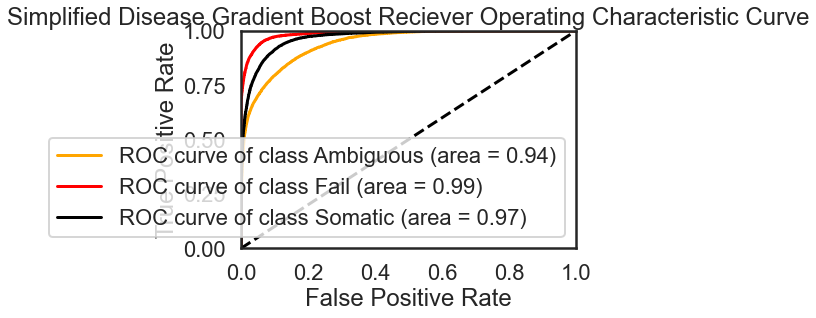

In [52]:
# Print ROC Curve for test set without reviewer
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Somatic'}
fig, ax = plt.subplots()
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Simplified Disease '
                 'Gradient Boost Reciever Operating Characteristic Curve', ax)

confidence intervals +-:  [0.00042457 0.00316549 0.00520891 0.00698728 0.00795647 0.00835649
 0.00765994 0.00585722 0.00361355 0.00075649]


C:\Users\shubh\Documents\applied machine learning\DeepSVR\analysis_utils\ClassifierPlots.py:96: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax2.plot([0, 1], [0, 1], 'k--', color='grey', linewidth=1)


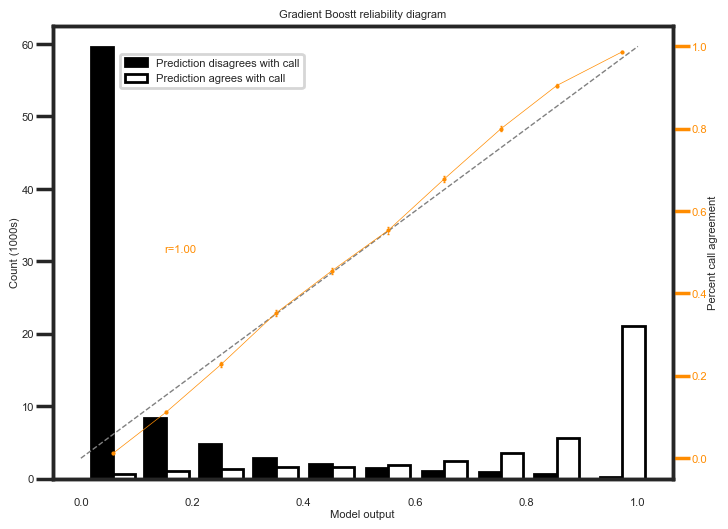

In [53]:
# Plot reliability diagram for test set without reviewer
fig, ax = plt.subplots(figsize=(8,6),dpi=100)
lgd = create_reliability_diagram(probabilities, Y_one_hot,['Ambiguous','Fail','Somatic'], 'darkorange', 'Gradient Boostt reliability diagram',
                                 ax, True, True, True)
lgd.set_bbox_to_anchor((0.1, .85))

In [54]:
# Format probabilities and store as xval_model_results
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [55]:
cv_somatic_error = get_somatic_error_type(Y_one_hot, predicted)

In [56]:
cv_somatic_error.index = training_data.index

In [57]:
probs_df = pd.DataFrame(probabilities, columns=['Ambiguous', 'Fail', 'Somatic'], index=training_data.index)

In [58]:
cv_somatic_error = pd.concat([cv_somatic_error, probs_df], axis=1)